In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
import requests
from PIL import Image
from tqdm import tqdm
from py_medoids import KMedoids, GMedoids

colors = [
    (1.0, 0.0, 0.0, 0.8), (0.0, 1.0, 0.0, 0.8), (0.0, 0.0, 1.0, 0.8),
    (1.0, 1.0, 0.0, 0.8), (1.0, 0.0, 1.0, 0.8), (0.0, 1.0, 1.0, 0.8),
    (0.5, 0.0, 0.0, 0.8), (0.0, 0.5, 0.0, 0.8), (0.0, 0.0, 0.5, 0.8),
    (1.0, 0.5, 0.0, 0.8), (0.0, 1.0, 0.5, 0.8), (0.5, 0.0, 1.0, 0.8),
    (1.0, 0.0, 0.5, 0.8), (0.5, 1.0, 0.0, 0.8), (0.0, 0.5, 1.0, 0.8),
]
im = Image.open("TH433.png").convert('P')

In [2]:
# get passes of statsbomb data in World Cup 2018
base_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
comp_url = base_url + "matches/{}/{}.json"
match_url = base_url + "events/{}.json"
competition_id = 43
season_id = 3

matches = requests.get(url=comp_url.format(competition_id, season_id)).json()
match_ids = [m['match_id'] for m in matches]

all_passes = []
all_players = {}

for match_id in tqdm(match_ids):

    events = requests.get(url=match_url.format(match_id)).json()
    passes = [x for x in events if x['type']['name'] == "Pass"]
            
    for p in passes:
        attributes = {
            "x": p['location'][0],
            "y": p['location'][1],
            "end_x": p['pass']['end_location'][0],
            "end_y": p['pass']['end_location'][1],
            "outcome": 0 if 'outcome' in p['pass'].keys() else 1,
            "team": p['team']['name'],
            "player": p['player']['name'],
        }
        all_passes.append(attributes)
        all_players[p['player']['name']] = p['player']['name']
        
pd_passes = pd.DataFrame(all_passes)
pd_passes.head()

100%|██████████| 64/64 [00:32<00:00,  1.98it/s]


,x,y,end_x,end_y,outcome,team,player
0,61.0,41.0,37.0,37.0,1,Denmark,Christian Dannemann Eriksen
1,38.0,42.0,97.0,57.0,0,Denmark,Mathias Jattah-Njie Jørgensen
2,24.0,24.0,48.0,33.0,0,Croatia,Domagoj Vida
3,73.0,48.0,68.0,48.0,1,Denmark,Thomas Delaney
4,75.0,50.0,82.0,53.0,0,Denmark,Andreas Christensen


In [3]:
# pass cluster with k = 4
features = ['x', 'y', 'end_x', 'end_y']
columns = [
    'c1_x', 'c1_y', 'c1_end_x', 'c1_end_y',
    'c2_x', 'c2_y', 'c2_end_x', 'c2_end_y',
    'c3_x', 'c3_y', 'c3_end_x', 'c3_end_y',
    'c4_x', 'c4_y', 'c4_end_x', 'c4_end_y'
    ]
centroids = pd.DataFrame(columns=columns)

for playerName, _ in tqdm(all_players.items()):
    pd_passes_i = pd_passes[pd_passes.player == playerName]
    if len(pd_passes_i) < 200: 
        continue
    pred_i = KMedoids(n_cluster=4).fit(squareform(pdist(pd_passes_i[features], metric='euclidean')))
    # sort clusters
    counts = list(np.argsort([
        np.count_nonzero(pred_i.results == 0), 
        np.count_nonzero(pred_i.results == 1), 
        np.count_nonzero(pred_i.results == 2), 
        np.count_nonzero(pred_i.results == 3)
        ]))[::-1]
    cluster_centers = pred_i.cluster_centers_.tolist()
    row = []
    for i in counts:
        row.append(pd_passes_i.iat[cluster_centers[i], 0]) # ci_x
        row.append(pd_passes_i.iat[cluster_centers[i], 1]) # ci_y
        row.append(pd_passes_i.iat[cluster_centers[i], 2]) # ci_end_x
        row.append(pd_passes_i.iat[cluster_centers[i], 3]) # ci_end_y
    centroids.loc[playerName] = row
    pd_passes_i = None

centroids.head()

100%|██████████| 600/600 [01:05<00:00,  9.21it/s]


,c1_x,c1_y,c1_end_x,c1_end_y,c2_x,c2_y,c2_end_x,c2_end_y,c3_x,c3_y,c3_end_x,c3_end_y,c4_x,c4_y,c4_end_x,c4_end_y
Domagoj Vida,51.0,23.0,64.0,20.0,28.0,23.0,40.0,12.0,25.0,29.0,29.0,39.0,56.0,30.0,65.0,52.0
Marcelo Brozović,42.0,54.0,38.0,60.0,40.0,23.0,41.0,25.0,65.0,58.0,77.0,55.0,68.0,24.0,81.0,13.0
Simon Thorup Kjær,50.0,54.0,57.0,67.0,32.0,56.0,33.0,35.0,46.0,49.0,53.0,29.0,50.0,63.0,102.0,49.0
Ivan Strinić,39.0,9.0,55.0,12.0,65.0,11.0,69.0,10.0,90.0,9.0,96.0,17.0,25.0,5.0,23.0,18.0
Ivan Rakitić,47.0,41.0,48.0,52.0,53.0,19.0,53.0,18.0,81.0,17.0,93.0,19.0,87.0,43.0,98.0,67.0


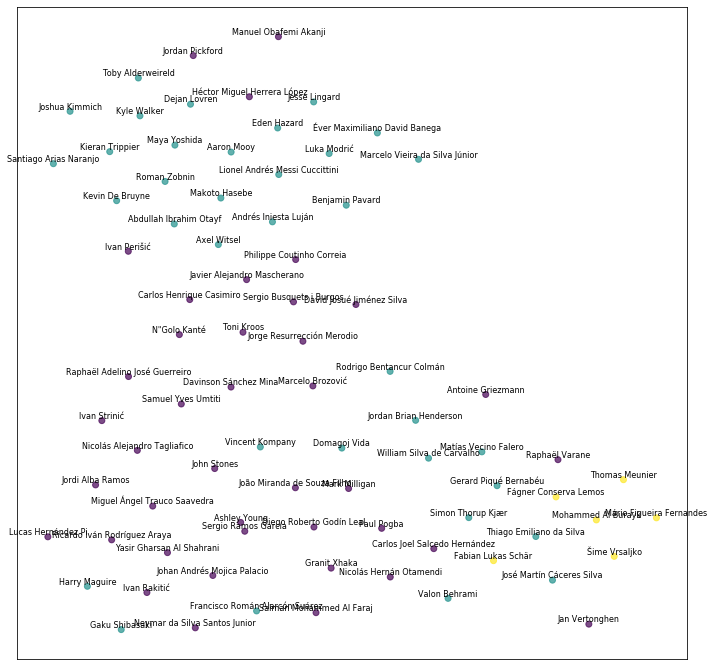

In [13]:
# t-SNE
Y = TSNE().fit_transform(centroids)
centroids['TSNE1'] = Y[:, 0]
centroids['TSNE2'] = Y[:, 1]

pred = GMedoids(n_cluster=2, max_iter=100).fit(centroids[columns])
centroids['cluster'] = pred.labels_

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_xticks([])
ax.set_yticks([])
plt.scatter(centroids['TSNE1'], centroids['TSNE2'], c=centroids['cluster'], alpha=0.7)
for index, row in centroids.iterrows():
    plt.text(row['TSNE1'], row['TSNE2'], index, ha='center', va='bottom', fontsize=8, color='black')

plt.show()